In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")


In [2]:
df = pd.read_csv("monthly_arima_data.csv")
df.head()

,month,revenue
0,"February, 2022","60,950.4"
1,"March, 2022","13,536,127.95"
2,"April, 2022","72,127,371.08"
3,"May, 2022","217,603,579.03"
4,"June, 2022","300,827,989.84"


In [3]:
df["month"] = pd.to_datetime(df["month"], format="%B, %Y", errors="coerce")

df["revenue"] = (
    df["revenue"]
      .astype(str)          
      .str.replace(",", "", regex=False)  
      .str.strip()           
)

df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

df = df.sort_values("month")
df.set_index("month", inplace=True)

print(df.head())
print(df.dtypes)

                 revenue
month                   
2022-02-01  6.095040e+04
2022-03-01  1.353613e+07
2022-04-01  7.212737e+07
2022-05-01  2.176036e+08
2022-06-01  3.008280e+08
revenue    float64
dtype: object


In [4]:
df.head()

,revenue
month,
2022-02-01,6.095040e+04
2022-03-01,1.353613e+07
2022-04-01,7.212737e+07
2022-05-01,2.176036e+08
2022-06-01,3.008280e+08


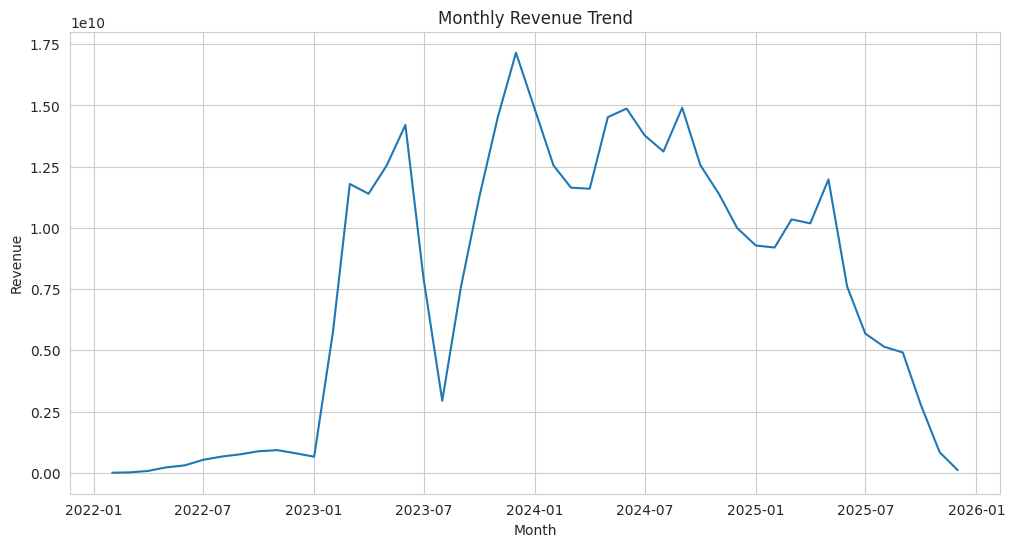

In [5]:
plt.plot(df.index, df["revenue"])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

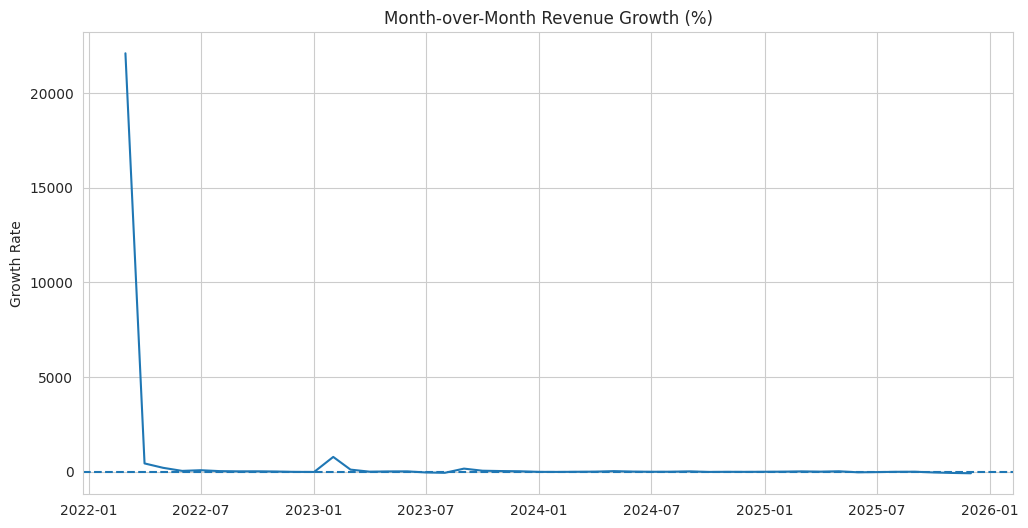

In [6]:
df["mom_growth"] = df["revenue"].pct_change() * 100

plt.plot(df.index, df["mom_growth"])
plt.axhline(0, linestyle="--")
plt.title("Month-over-Month Revenue Growth (%)")
plt.ylabel("Growth Rate")
plt.savefig("Month-over-Month Revenue Growth.png", dpi=300, bbox_inches="tight")
plt.show()

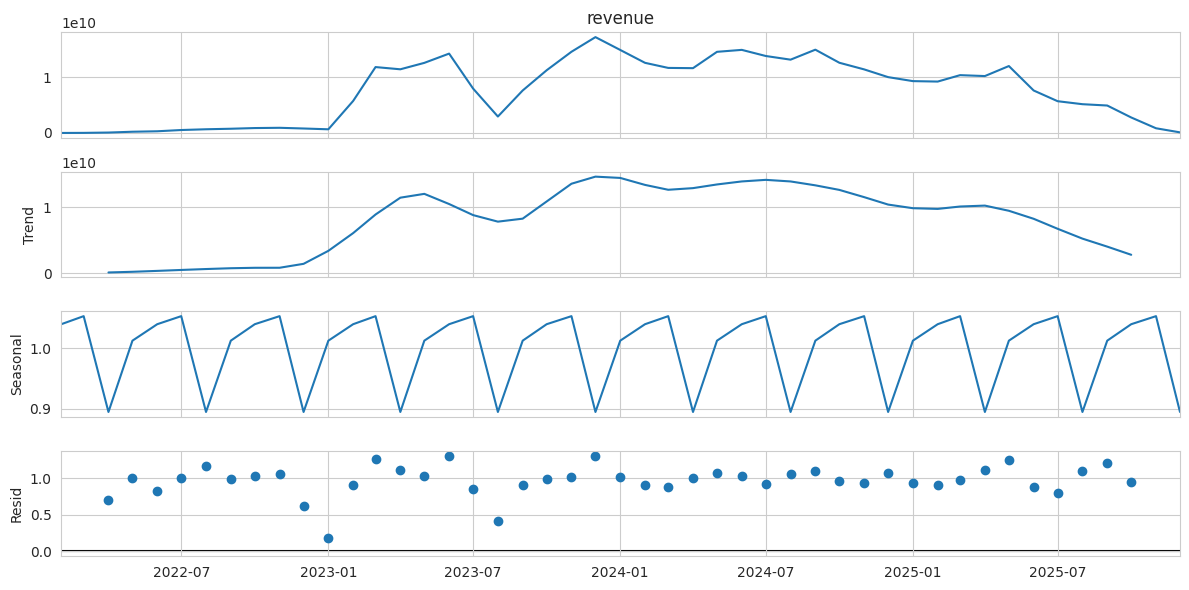

In [7]:
#seasonality

decomposition = seasonal_decompose(df["revenue"], model="multiplicative", period=4)
decomposition.plot()
plt.show()

In [8]:
#Checking for stationarity

adf_result = adfuller(df["revenue"])

print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

ADF Statistic: -2.0416805630277004
P-value: 0.2686017802556303


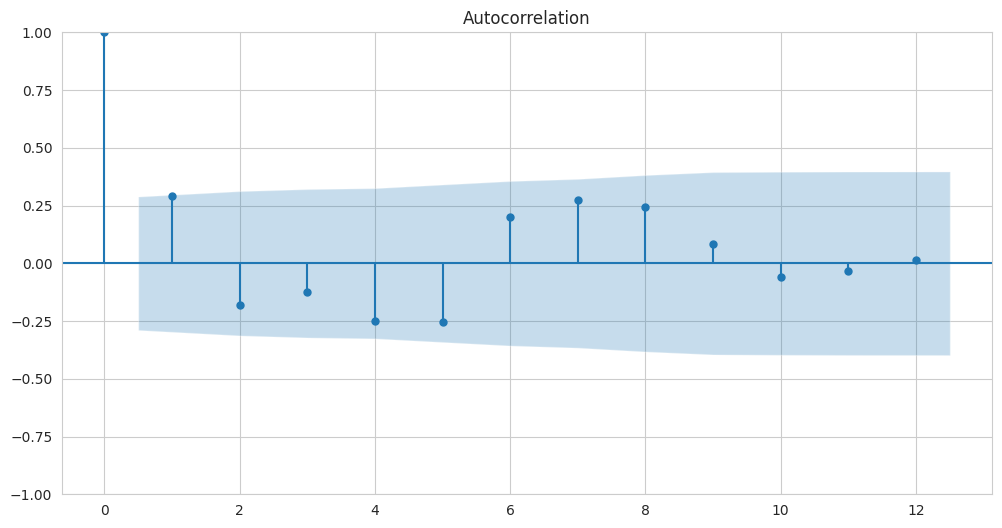

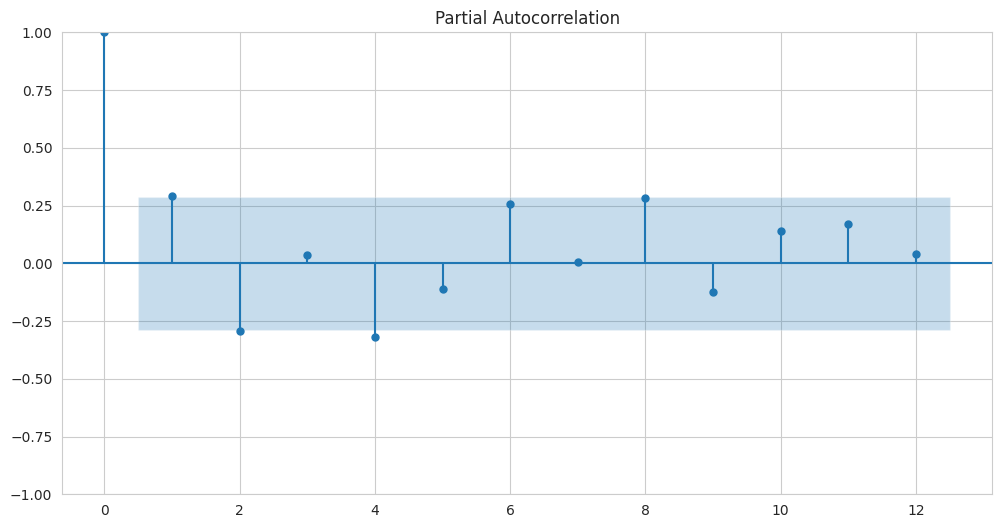

In [9]:
#applying autocorrection p = 0.27

plot_acf(df["revenue"].diff().dropna(), lags=12)
plt.show()

plot_pacf(df["revenue"].diff().dropna(), lags=12)
plt.show()

In [15]:
df["revenue_log"] = np.log(df["revenue"])

model = SARIMAX(
    df["revenue_log"],
    order=(1, 1, 1),             
    seasonal_order=(1, 1, 1, 12),  
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        revenue_log   No. Observations:                   47
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -12.972
Date:                            Mon, 15 Dec 2025   AIC                             35.944
Time:                                    07:23:51   BIC                             40.923
Sample:                                02-01-2022   HQIC                            36.916
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8307      0.839      0.990      0.322      -0.814       2.476
ma.L1          0.1251      1.120   

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [16]:
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

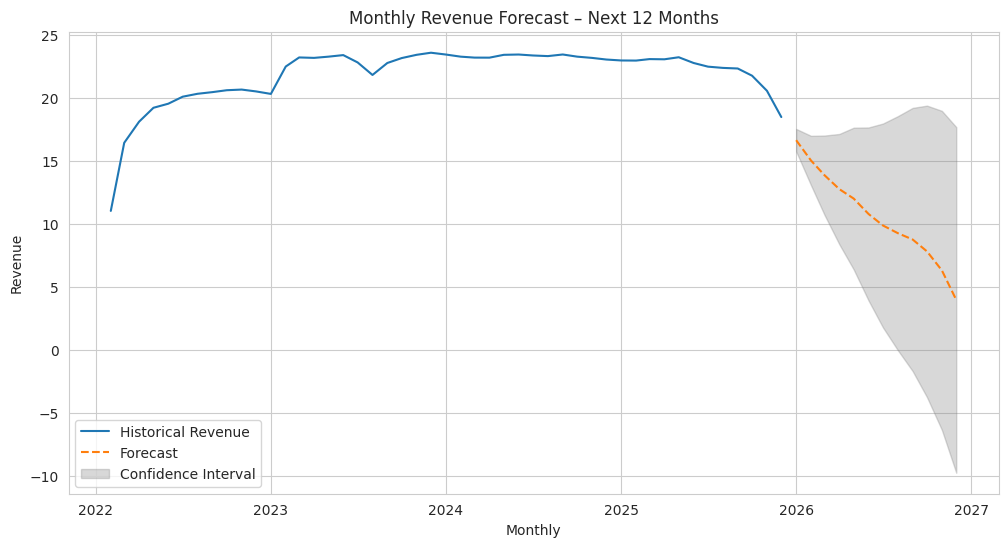

In [17]:
plt.plot(df.index, df["revenue_log"], label="Historical Revenue")
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label="Forecast", linestyle="--")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="gray",
    alpha=0.3,
    label="Confidence Interval"
)

plt.title("Monthly Revenue Forecast – Next 12 Months")
plt.xlabel("Monthly")
plt.ylabel("Revenue")
plt.legend()
plt.savefig("monthly_revenue_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
forecast_df = pd.DataFrame({
    "Quarter": forecast.predicted_mean.index,
    "Expected_Revenue": np.exp(forecast.predicted_mean.values),
    "Lower_Bound": np.exp(forecast_ci.iloc[:, 0].values),
    "Upper_Bound": np.exp(forecast_ci.iloc[:, 1].values)
})

#round to nearest Naira
forecast_df[["Expected_Revenue", "Lower_Bound", "Upper_Bound"]] = forecast_df[["Expected_Revenue", "Lower_Bound", "Upper_Bound"]].round(0)

forecast_df